## 🧠 任務說明：COVID-19 CT 語義分割任務

本任務的目標是針對 **COVID-19 CT 切片影像中的病灶區域進行語義分割**，特別關注兩種肺部病變：

| 類別代碼 | 病變類型                       |
|----------|-------------------------------|
| 0        | Ground-glass opacities（毛玻璃陰影） |
| 1        | Consolidations（實變）             |

你需要根據提供的測試影像 `test_images_medseg.npy`，**預測出每張影像對應的 segmentation mask（只有上述兩類）**。

---

## 📁 資料結構說明

| 檔案名稱               | 說明 |
|------------------------|------|
| `images_medseg.npy`    | 100 張訓練影像，大小為 512x512 |
| `masks_medseg.npy`     | 對應的 100 張訓練 mask，大小為 512x512x4，其中：<br> - channel 0: ground glass<br> - channel 1: consolidations<br> - channel 2: lungs other<br> - channel 3: background |
| `test_images_medseg.npy` | 10 張要預測的測試影像 |
| `images_radiopedia.npy`| 額外提供的 829 張訓練影像 |
| `masks_radiopedia.npy` | 對應的 829 張訓練 mask（4 個通道，結構同上）|

---

## 🎯 任務操作步驟簡化版

1. **輸入資料：**
   - `images_medseg.npy`, `images_radiopedia.npy`

2. **使用標註：**
   - `masks_medseg.npy`, `masks_radiopedia.npy`
   - 只取用 channel 0 和 1（即 ground glass 與 consolidation）

3. **模型訓練：**
   - 使用語義分割模型（例如 U-Net、DeepLabV3、SegFormer 等）

4. **預測測試資料：**
   - `test_images_medseg.npy`，預測 10 張對應的 mask

5. **輸出格式：**
   - 每張影像預測一張 mask，形狀為 `(512, 512)`，每個像素值為 0（GGO）或 1（Consolidation）

---

## 📌 注意事項

- 雖然原始 mask 有 4 個 channel，但 **任務只評估 channel 0 和 1 的預測結果**
- 可以使用其他公開 COVID-19 CT segmentation 資料（如 [https://mosmed.ai](https://mosmed.ai)），但需公開分享使用連結
- 預測模型需能分辨「無病灶的正常切片」與「有病灶的切片」


In [1]:
import numpy as np # linear algebra
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
import os
images_medseg = np.load('/kaggle/input/covid-segmentation/images_medseg.npy').astype(np.float32)
images_radiopedia = np.load('/kaggle/input/covid-segmentation/images_radiopedia.npy').astype(np.float32)
masks_medseg = np.load('/kaggle/input/covid-segmentation/masks_medseg.npy').astype(np.float32)
masks_radiopedia = np.load('/kaggle/input/covid-segmentation/masks_radiopedia.npy').astype(np.float32)
test_images_medseg = np.load('/kaggle/input/covid-segmentation/test_images_medseg.npy').astype(np.float32)

In [3]:
images_medseg.shape,images_radiopedia.shape,masks_medseg.shape,masks_radiopedia.shape,test_images_medseg.shape,

((100, 512, 512, 1),
 (829, 512, 512, 1),
 (100, 512, 512, 4),
 (829, 512, 512, 4),
 (10, 512, 512, 1))

In [4]:
import matplotlib.pyplot as plt
def show_img(img_array, index=0):
    fig = plt.figure(figsize=(10, 3))
    for i in range(1):
        ax = fig.add_subplot(1, 1, i + 1, xticks=[], yticks=[])
        ax.imshow(img_array[index + i].squeeze())
        ax.set_title(f'index {index + i}')
    plt.show()
    
def show_mask(img_array, index=0):
    fig = plt.figure(figsize=(20, 5))
    channels = 4
    for c in range(channels):
        ax = fig.add_subplot(1, channels, c + 1, xticks=[], yticks=[])
        ax.imshow(img_array[index, :, :, c])
        ax.set_title(f'Channel {c}')
    plt.show()

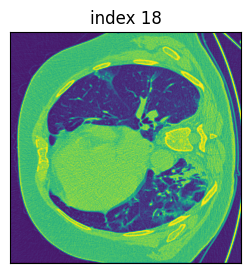

In [5]:
show_img(images_medseg, index=18)

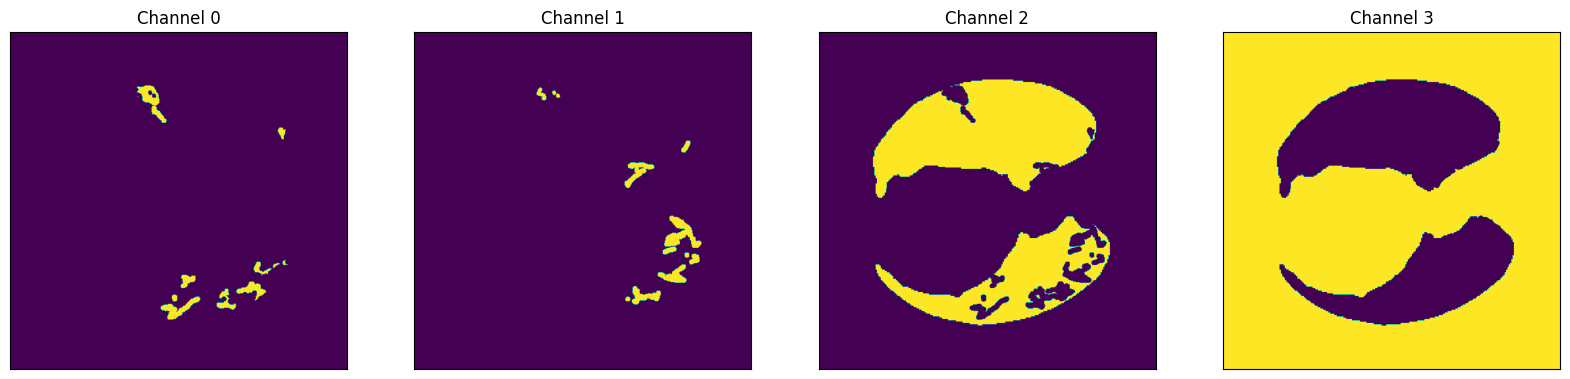

In [6]:
show_mask(masks_medseg, index=18)

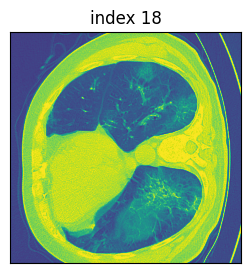

In [7]:
show_img(images_radiopedia, index=18)

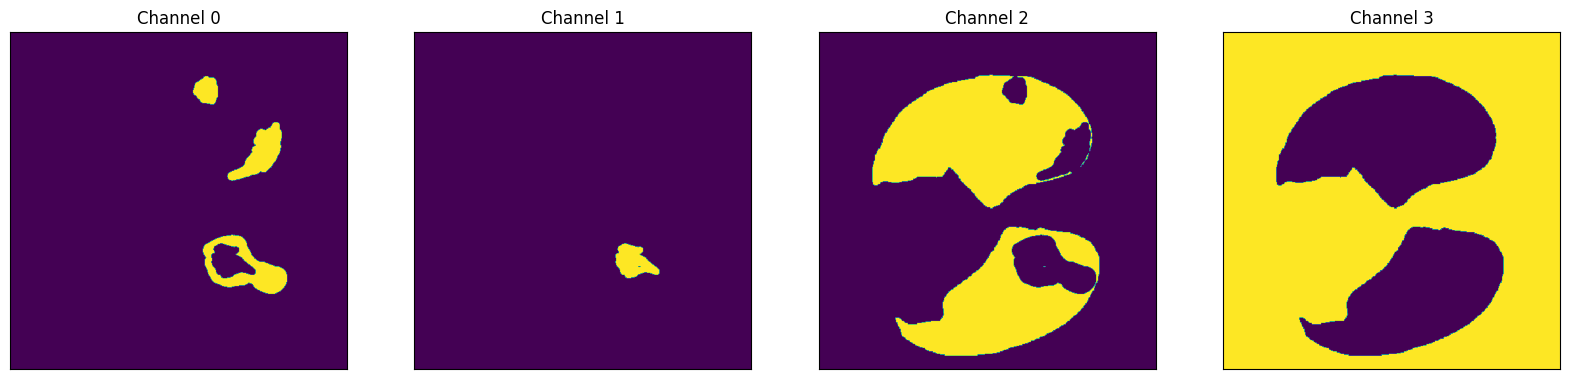

In [8]:
show_mask(masks_radiopedia, index=18)

## Images from radiopedia are full CT volumes:
- Class 0 is "ground glass"
- Class 1 is "consolidations"
- Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (you don't need to predict this class)
- Class 3 is "background" – not lungs (you don't need to predict this class)

## Normolize

In [9]:
def normalize_ct(image, min_bound=-1000.0, max_bound=400.0):
    image = np.clip(image, min_bound, max_bound)
    image = (image - min_bound) / (max_bound - min_bound)
    return image


In [10]:
# 對所有影像集都做 normalization
images_medseg = normalize_ct(images_medseg)
images_radiopedia = normalize_ct(images_radiopedia)
test_images_medseg = normalize_ct(test_images_medseg)

### 先用純masks_radiopedia訓練一版模型，再用medseg微調

In [11]:
'''
抓出 GGO 的像素位置（channel 0 為 1 的地方，並在combined_mask設1
抓出 Consolidation 的像素位置（channel 1 為 1 的地方，並在combined_mask設2
最後得到pixel wise的標註 0為背景、1為GGO、2為Consolidation

'''
def prepare_combined_mask(masks):
    # 0: 背景, 1: GGO, 2: Consolidation
    combined_mask = np.zeros((masks.shape[0], 512, 512), dtype=np.uint8)
    combined_mask[masks[:, :, :, 0] == 1] = 1  # GGO
    combined_mask[masks[:, :, :, 1] == 1] = 2  # Consolidation
    return combined_mask
    
# 呼叫轉換
y_all = prepare_combined_mask(masks_radiopedia)
y_all.shape

(829, 512, 512)

In [12]:
images_radiopedia.shape

(829, 512, 512, 1)

In [13]:
from sklearn.model_selection import train_test_split
X_all = images_radiopedia
# 切分訓練/驗證
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [14]:
X_train.shape, X_val.shape,X_all.shape

((663, 512, 512, 1), (166, 512, 512, 1), (829, 512, 512, 1))

## 模型

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(512, 512, 1), num_classes=3):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # 輸出：每 pixel 為類別編號 (0~2)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

2025-07-28 00:17:08.253635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753661828.608175      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753661828.706635      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
model = build_unet(input_shape=(512, 512, 1), num_classes=3)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

I0000 00:00:1753661847.026657      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753661847.027331      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]

 Total params: 31,377,923 (119.70 MB)

 Trainable params: 31,377,923 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping：val_loss 3 次沒改善就停止
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# ModelCheckpoint：儲存 val_loss 最佳模型
checkpoint = ModelCheckpoint(
    filepath='best_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 訓練：y_train shape = (N, 512, 512)，不需要 one-hot
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=4,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 1))
  warnings.warn(msg)
I0000 00:00:1753661860.071498     102 service.cc:148] XLA service 0x7cee2c0219b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753661860.072887     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753661860.072921     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1753661860.586263     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1753661861.038569     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-28 00:18:02.918018: E external/local_xla/xla/service/slow_operation

165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.9278 - loss: 0.5845

W0000 00:00:1753662094.259965     103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-28 00:21:54.519688: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[3,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,192,512,512]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-28 00:21:55.831437: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.3119423s
Trying algorithm eng0{} for conv (f32[3,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9281 - loss: 0.5822   

W0000 00:00:1753662164.421615     103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-28 00:23:08.655034: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,192,512,512]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-28 00:23:10.758460: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.103566832s
Trying algorithm eng0{} for conv (f32[4,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[


Epoch 1: val_loss improved from inf to 0.04866, saving model to best_unet_model.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9284 - loss: 0.5799 - val_accuracy: 0.9875 - val_loss: 0.0487
Epoch 2/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9868 - loss: 0.0503
Epoch 2: val_loss improved from 0.04866 to 0.03541, saving model to best_unet_model.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9868 - loss: 0.0503 - val_accuracy: 0.9875 - val_loss: 0.0354
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9889 - loss: 0.0343
Epoch 3: val_loss improved from 0.03541 to 0.02654, saving model to best_unet_model.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9889 - loss: 0.0342 - val_accuracy: 0.9927 - val_loss: 0.0265
Epoch 4/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9918 - loss: 0.0277
Epoch 4: val_loss improved from 0.02654 to 0.02639, saving model to best_unet_model.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/

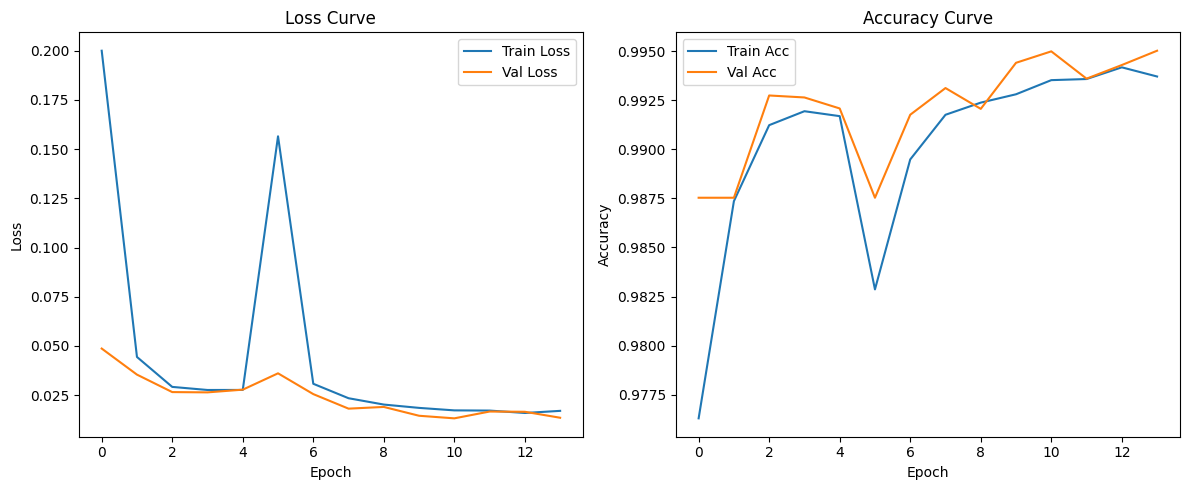

In [18]:
def plot_training_history(history):
    # 繪製 Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 繪製 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 呼叫畫圖
plot_training_history(history)

## TEST

In [19]:
test_images_medseg.shape

(10, 512, 512, 1)

In [20]:
# 執行預測，結果為 softmax 機率圖，shape: (10, 512, 512, 3)
preds_prob = model.predict(test_images_medseg)

# 取每個像素機率最大的類別，得到最終預測 mask，shape: (10, 512, 512)
preds_mask = np.argmax(preds_prob, axis=-1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 512, 512, 1))
  warnings.warn(msg)
2025-07-28 01:00:41.452092: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[10,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,512,512]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-28 01:00:42.994212: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.542230811s
Trying algorithm eng0{} for 

1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step


In [21]:
# preds_mask: (10, 512, 512)，0=背景, 1=GGO, 2=Consolidation
pred_submission = np.zeros((10, 512, 512, 2), dtype=np.uint8)

# GGO
pred_submission[:, :, :, 0] = (preds_mask == 1).astype(np.uint8)

# Consolidation
pred_submission[:, :, :, 1] = (preds_mask == 2).astype(np.uint8)

In [22]:
print(pred_submission.shape)  # (10, 512, 512, 2)


(10, 512, 512, 2)


In [33]:
submission_df = pd.DataFrame(
    data=np.stack((
        np.arange(pred_submission.size),
        pred_submission.ravel()
    ), axis=-1),
    columns=['Id', 'Predicted']
)

submission_df.to_csv('submission.csv', index=False)


In [31]:
counts = submission_df['Predicted'].value_counts().sort_index()
percent = submission_df['Predicted'].value_counts(normalize=True).sort_index() * 100

distribution = pd.DataFrame({
    'Label': counts.index,
    'Count': counts.values,
    'Percentage (%)': percent.values.round(2)
})

print(distribution)


   Label    Count  Percentage (%)
0      0  5153164           98.29
1      1    89716            1.71


In [28]:
import numpy as np
unique_values, counts = np.unique(preds_mask, return_counts=True)
print("預測值分布：")
for val, cnt in zip(unique_values, counts):
    print(f"類別 {val}: {cnt} 筆")


預測值分布：
類別 0: 2531724 筆
類別 1: 78064 筆
類別 2: 11652 筆


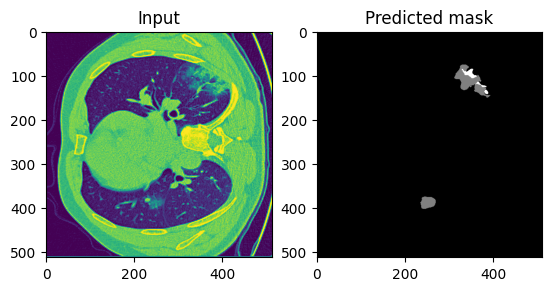

In [25]:
i = 0
plt.subplot(1, 2, 1)
plt.imshow(test_images_medseg[i])  # 原圖
plt.title("Input")

plt.subplot(1, 2, 2)
plt.imshow(preds_mask[i], cmap='gray')  # 預測
plt.title("Predicted mask")
plt.show()


In [26]:
test_images_medseg.shape

(10, 512, 512, 1)

In [27]:
np.unique(test_images_medseg, return_counts=True)

(array([0.000000e+00, 4.359654e-08, 8.719308e-08, ..., 9.998488e-01,
        9.999934e-01, 1.000000e+00], dtype=float32),
 array([451210,     59,     34, ...,      1,      1,   3794]))